# Car Object Detection

In [1]:
# install yolov8
!pip install ultralytics

In [2]:
from ultralytics import YOLO
import os
import random
import shutil
import numpy as np
import pandas as pd
import cv2
import yaml
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split

## Setting parameters

In [3]:
DIR = "kaggle/working/datasets/cars/"
IMAGES = DIR +"images/"
LABELS = DIR +"labels/"
TRAIN = "kaggle/input/car-object-detection/data/training_images"
TEST = "kaggle/input/car-object-detection/data/testing_images"

In [4]:
df = pd.read_csv("kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


## Setting dataset

In [5]:
files = list(df.image.unique())
files_train, files_valid = train_test_split(files, test_size = 0.2)

In [6]:
# !rm -r /kaggle/working/dataset

In [7]:
# make directories
os.makedirs(IMAGES+"train", exist_ok=True)
os.makedirs(LABELS+"train", exist_ok=True)
os.makedirs(IMAGES+"valid", exist_ok=True)
os.makedirs(LABELS+"valid", exist_ok=True)

In [8]:
train_filename = set(files_train)
valid_filename = set(files_valid)
for file in glob.glob(TRAIN+"/*"):
    fname =os.path.basename(file)
    if fname in train_filename:
        shutil.copy(file, IMAGES+"train")
    elif fname in valid_filename:
        shutil.copy(file, IMAGES+"valid")

In [9]:
for _, row in df.iterrows():    
    image_file = row['image']
    class_id = "0"
    x = row['xmin']
    y = row['ymin']
    width = row['xmax'] - row['xmin']
    height = row['ymax'] - row['ymin']

    x_center = x + (width / 2)
    y_center = y + (height / 2)
    x_center /= 676
    y_center /= 380
    width /= 676
    height /= 380

    if image_file in train_filename:   
        annotation_file = os.path.join(LABELS) + "train/" + image_file.replace('.jpg', '.txt')
    else:
        annotation_file = os.path.join(LABELS) + "valid/" + image_file.replace('.jpg', '.txt')
        
    with open(annotation_file, 'a') as ann_file:
        ann_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

## Setup yaml file

In [10]:
%%writefile dataset.yaml
# Path
path: /Users/nicholastjandra/documents/flatiron/phase_5/CarObjectDetection/kaggle/working/datasets/cars
train: images/train
val: images/valid

# Classes
nc: 1
names: ['car']

Overwriting dataset.yaml


## Disable wandb

In [11]:
# disable wandb
import wandb
wandb.init(mode="disabled")

## Training the Model

In [12]:
model = YOLO('yolov8n.pt')
model.train(data="dataset.yaml", epochs=20, batch=8)

Ultralytics YOLOv8.0.184 🚀 Python-3.9.16 torch-2.0.1 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=20, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=Fals

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x167abbd90>
fitness: 0.7397819016030314
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.71179])
names: {0: 'car'}
plot: True
results_dict: {'metrics/precision(B)': 0.9728992320302233, 'metrics/recall(B)': 0.9927007299270073, 'metrics/mAP50(B)': 0.9916763811382054, 'metrics/mAP50-95(B)': 0.7117936260991231, 'fitness': 0.7397819016030314}
save_dir: PosixPath('runs/detect/train7')
speed: {'preprocess': 0.42593134620975204, 'inference': 100.68084738847148, 'loss': 7.855409831669979e-05, 'postprocess': 0.31957323151516775}

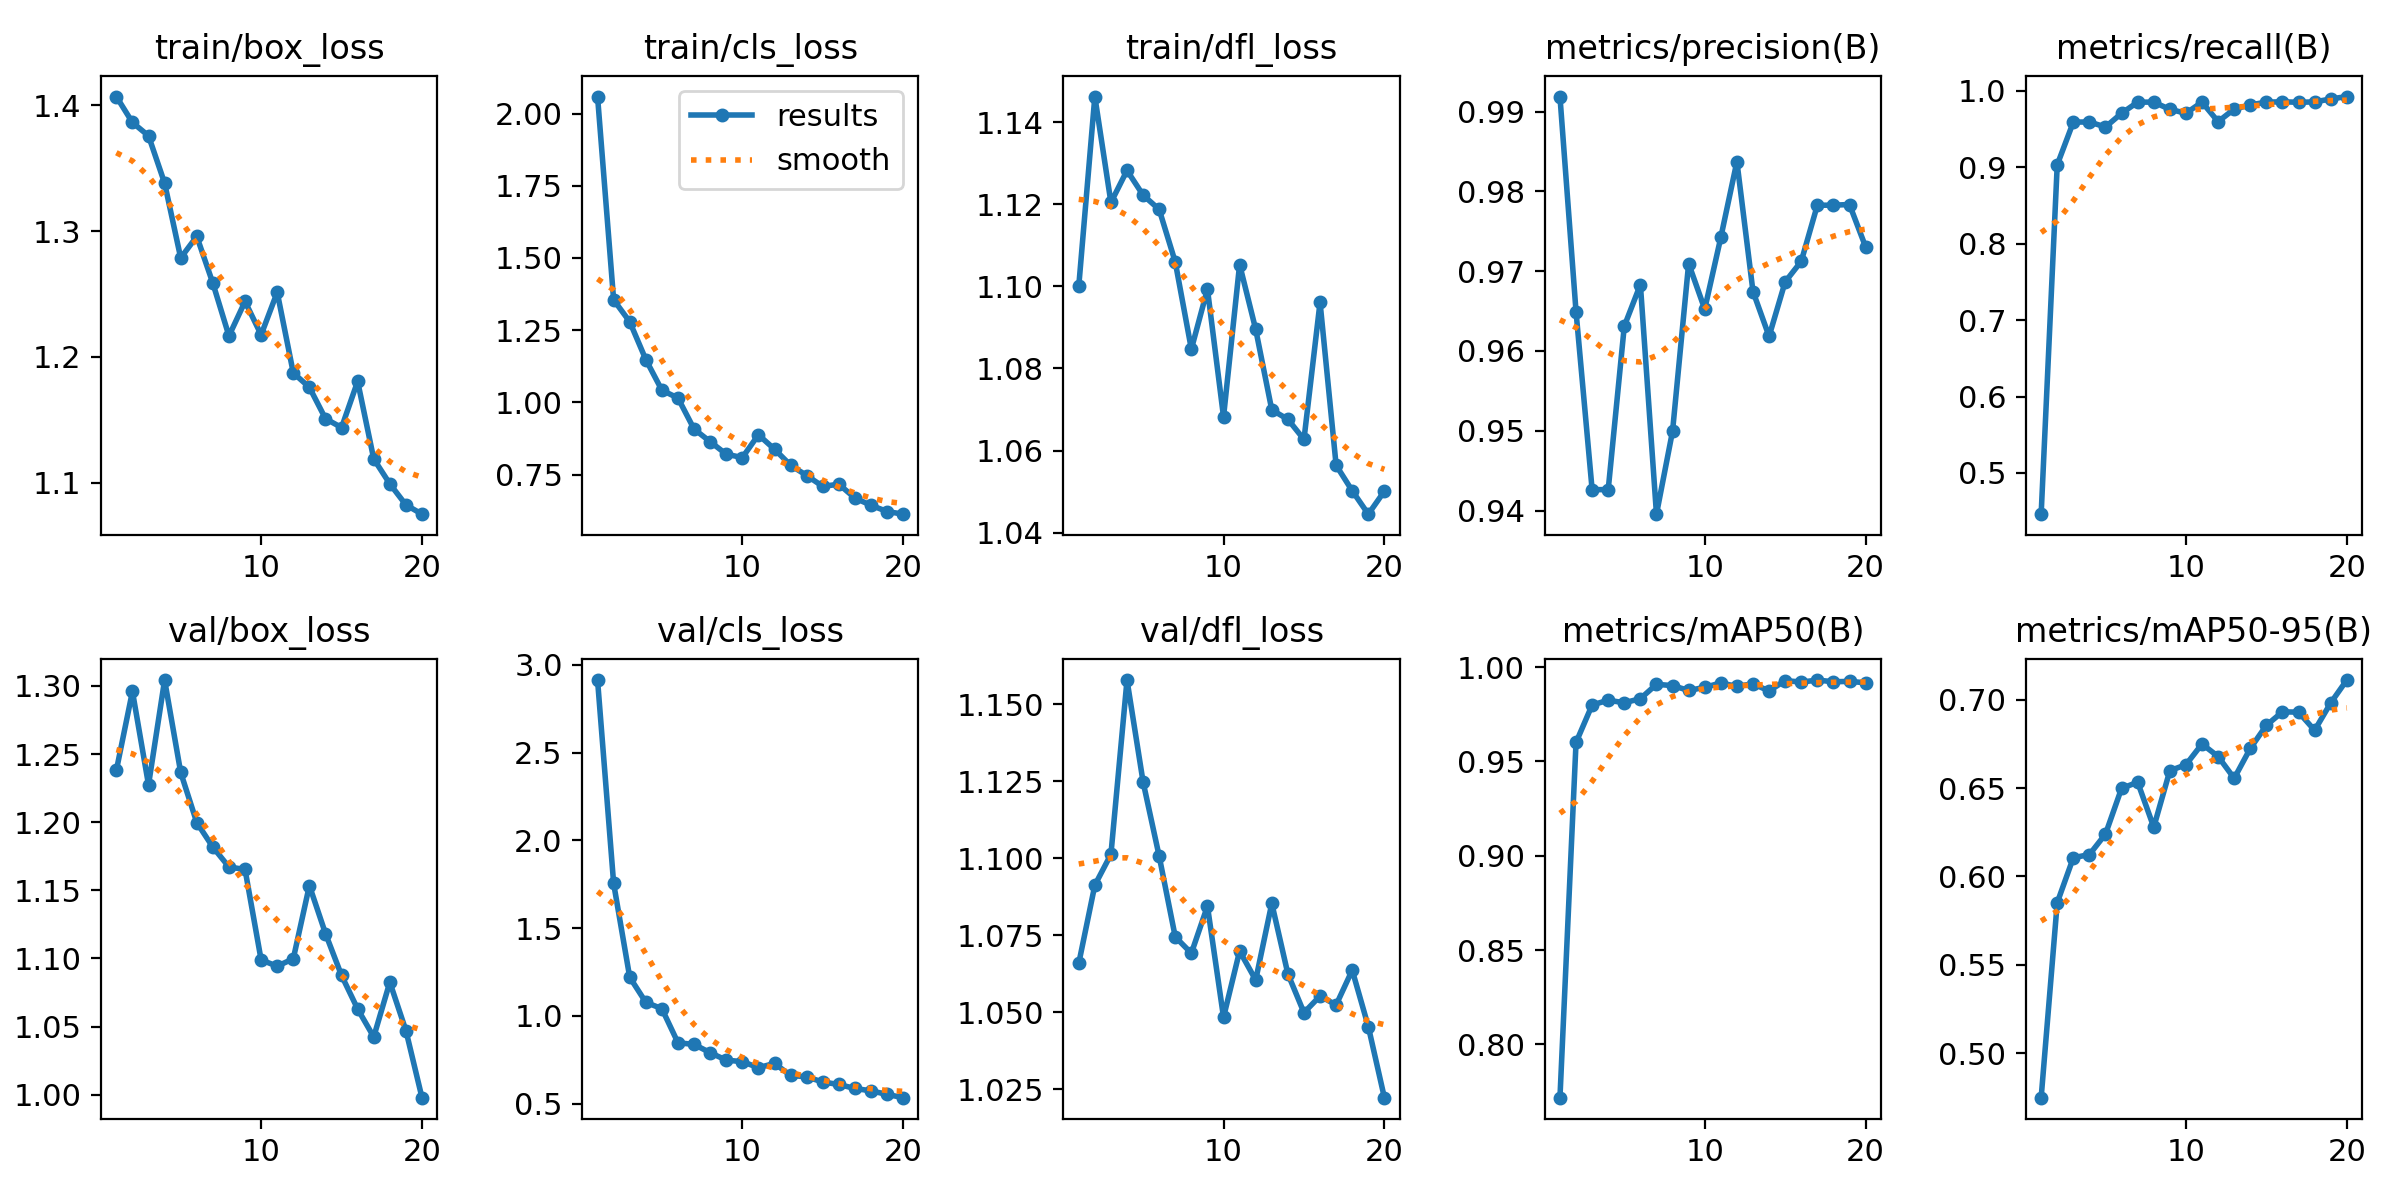

In [18]:
from IPython.display import Image

Image("runs/detect/train7/results.png")

## Plot Confusion Matrix

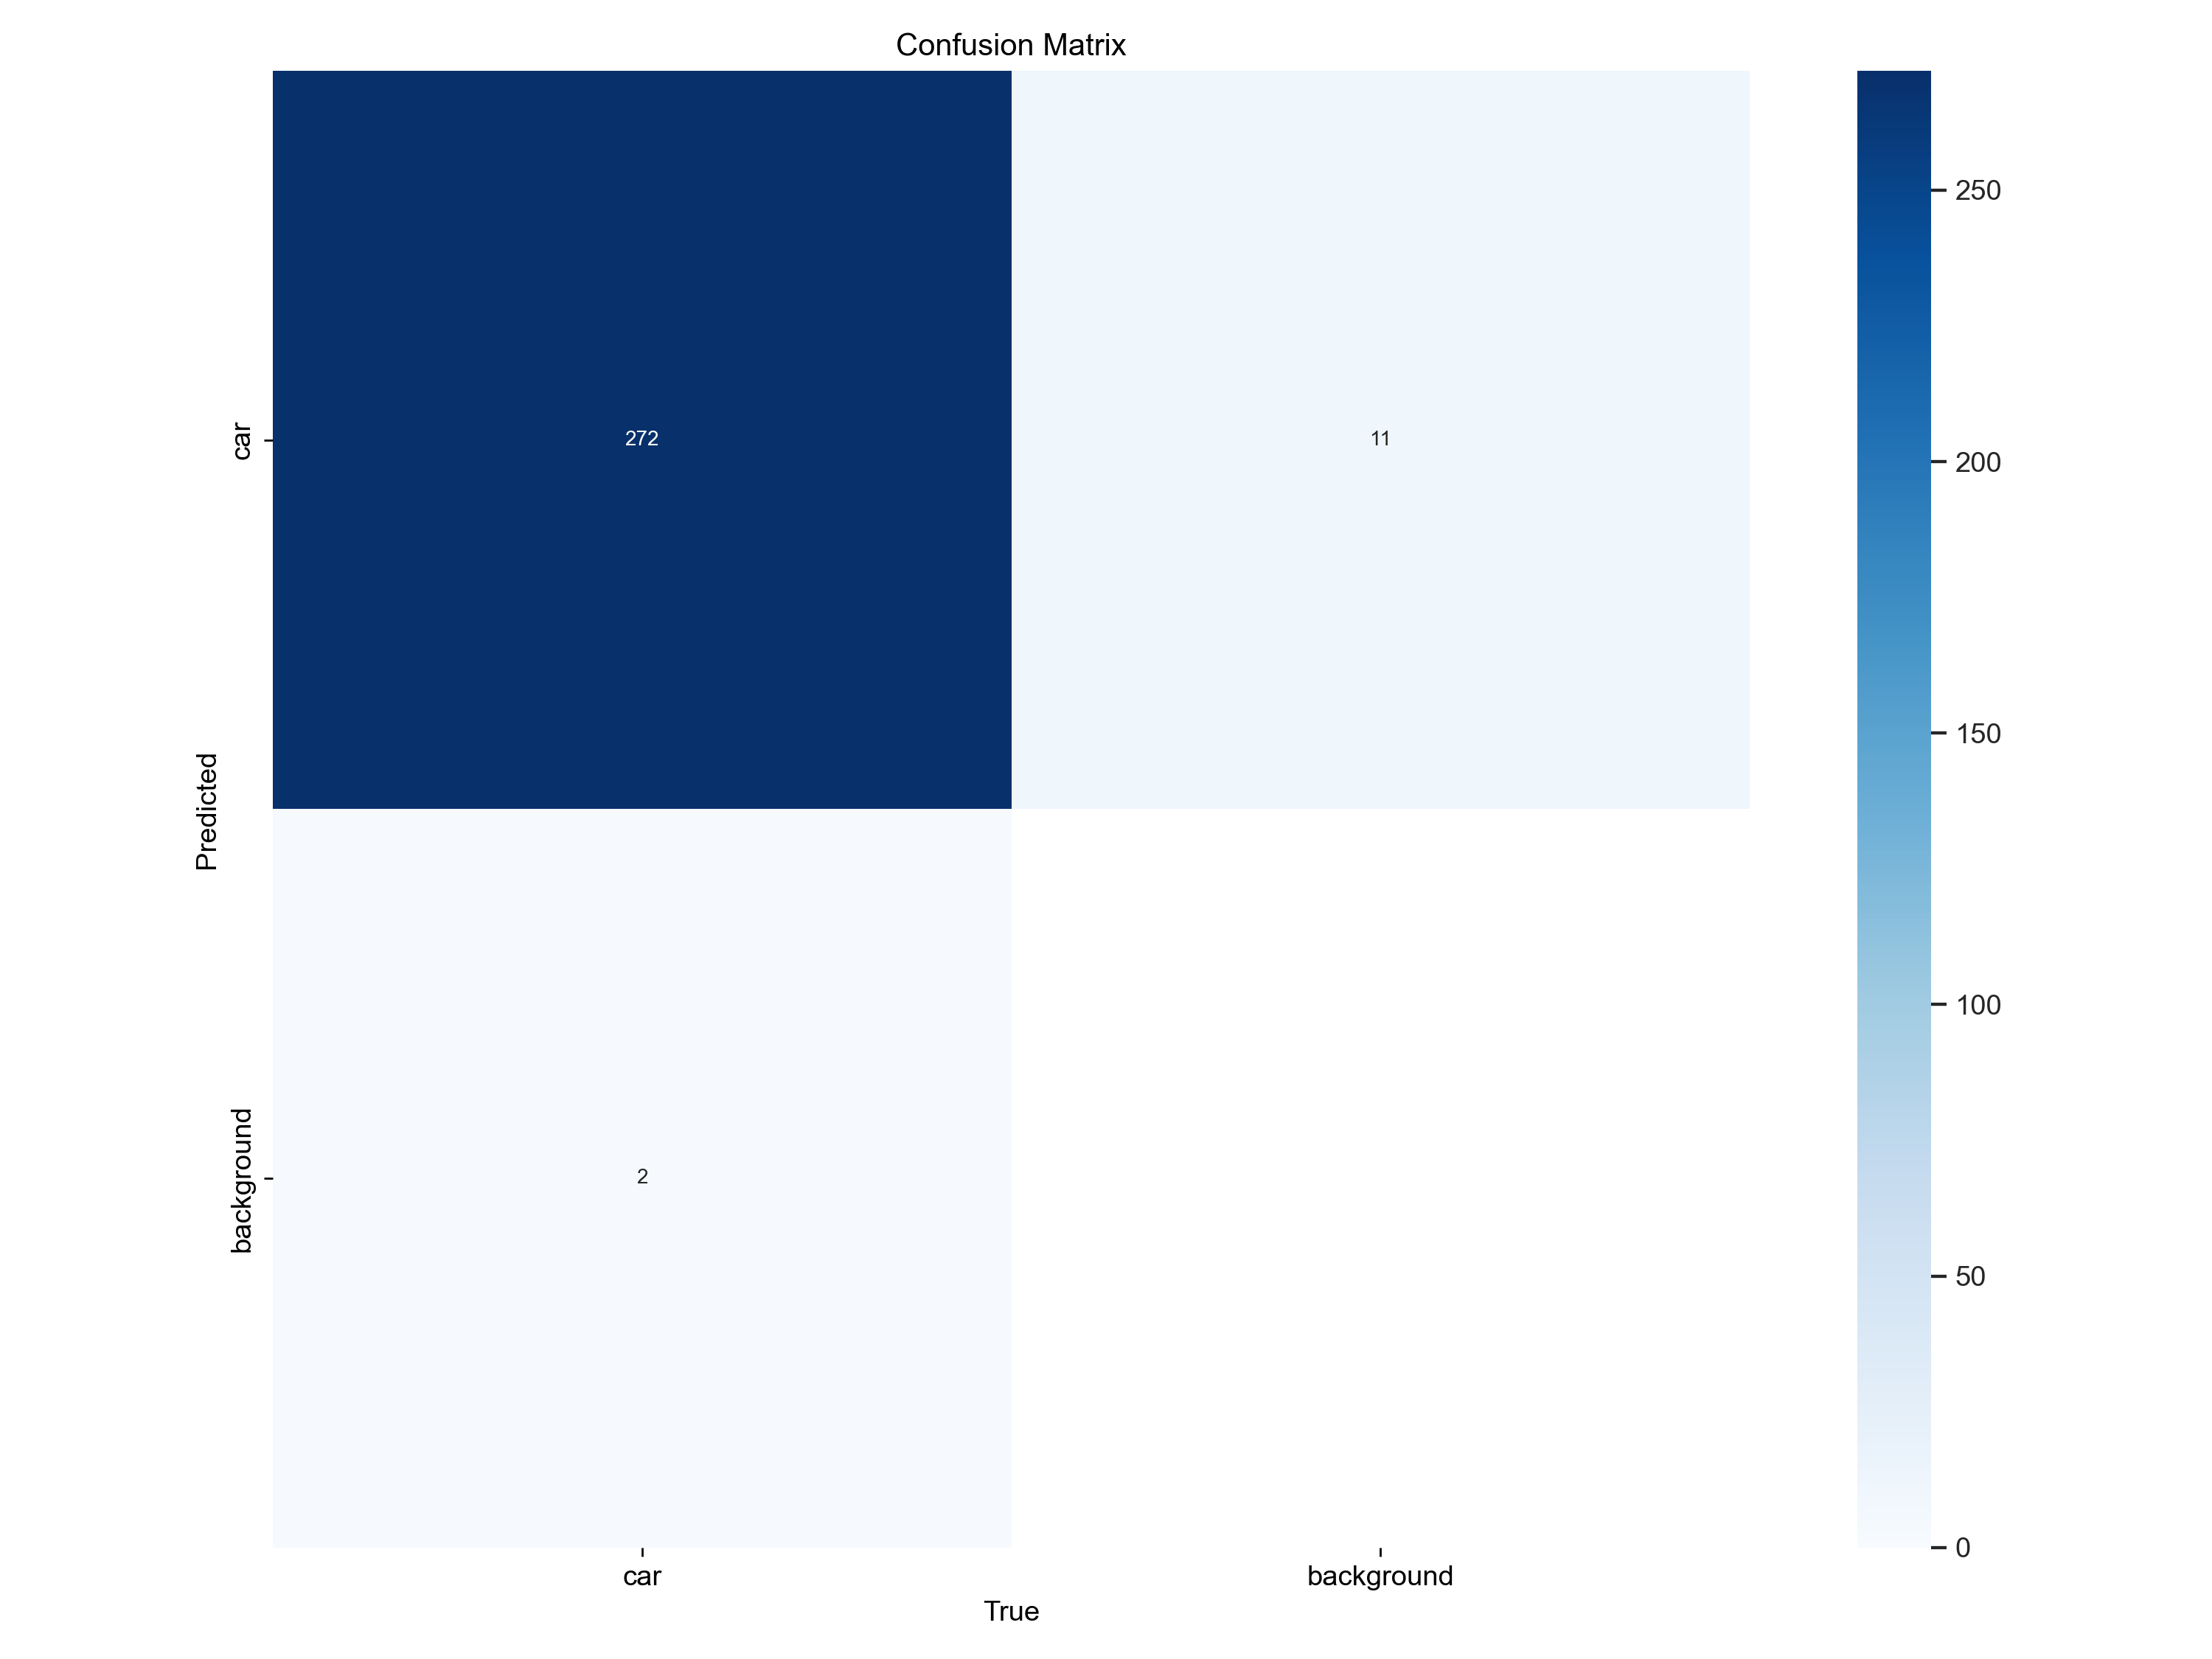

In [23]:
Image("runs/detect/train7/confusion_matrix.png")

## Running on test set

In [19]:
model = YOLO('runs/detect/train7/weights/last.pt')
ret = model("kaggle/input/car-object-detection/data/testing_images",save=True, conf=0.2, iou=0.5)


image 1/175 /Users/nicholastjandra/Documents/Flatiron/phase_5/CarObjectDetection/kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 42.9ms
image 2/175 /Users/nicholastjandra/Documents/Flatiron/phase_5/CarObjectDetection/kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 42.2ms
image 3/175 /Users/nicholastjandra/Documents/Flatiron/phase_5/CarObjectDetection/kaggle/input/car-object-detection/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 38.6ms
image 4/175 /Users/nicholastjandra/Documents/Flatiron/phase_5/CarObjectDetection/kaggle/input/car-object-detection/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 38.3ms
image 5/175 /Users/nicholastjandra/Documents/Flatiron/phase_5/CarObjectDetection/kaggle/input/car-object-detection/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 38.3ms
image 6/175 /Users/nicholastjandra/Documents/Flatiron/phase_5/CarObjectDetectio

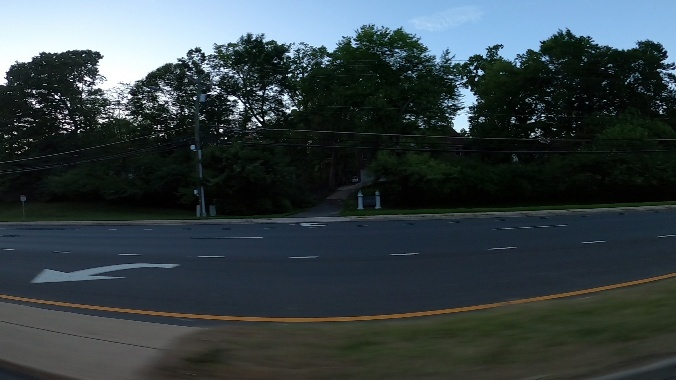

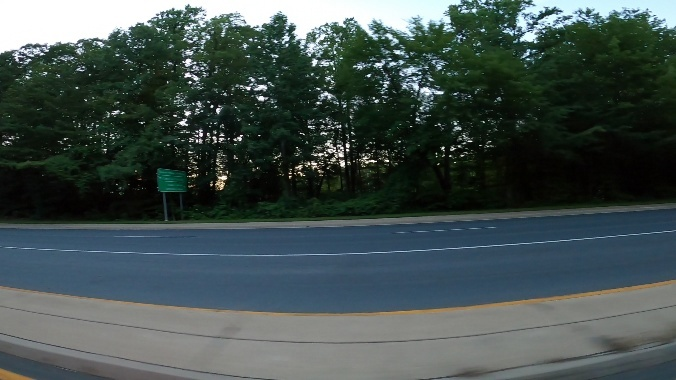

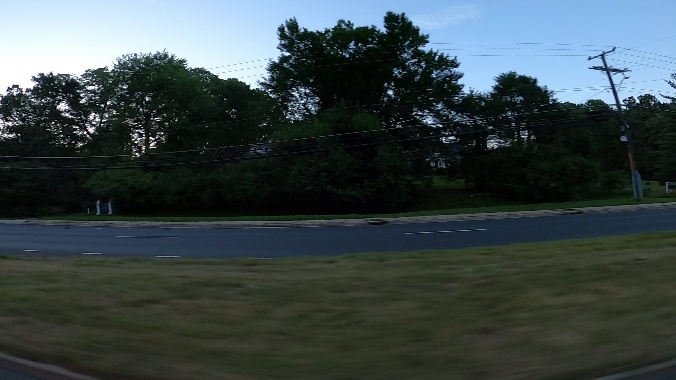

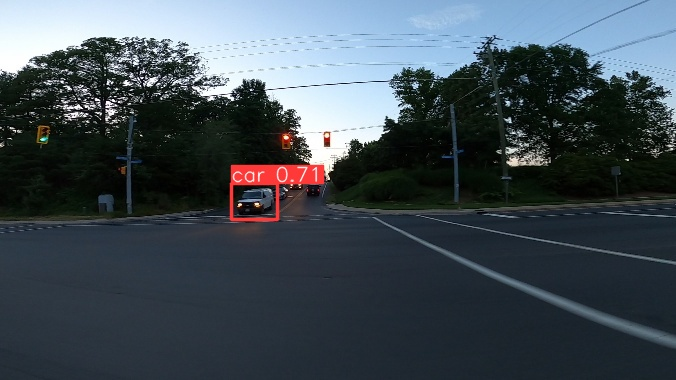

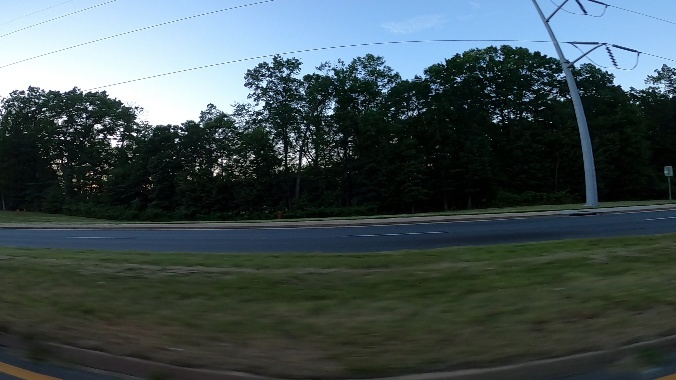

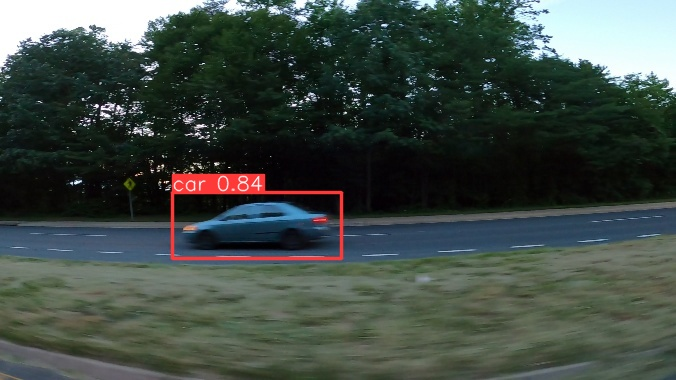

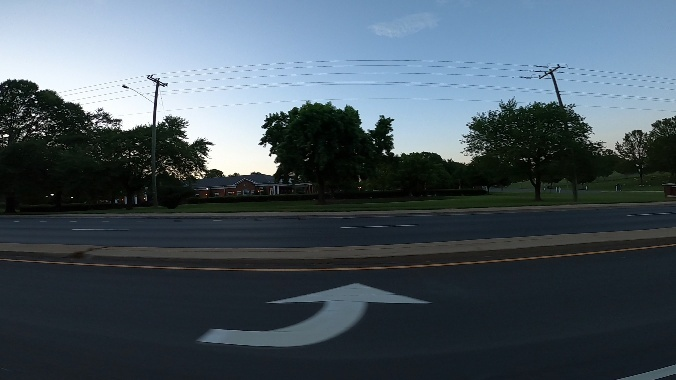

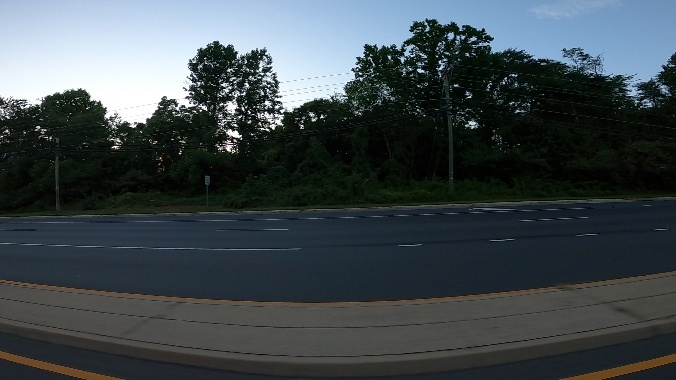

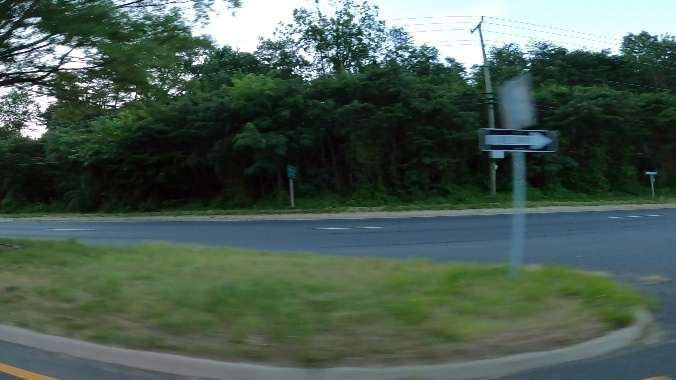

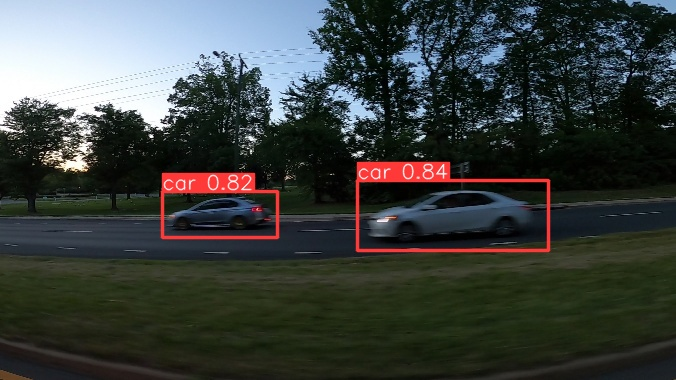

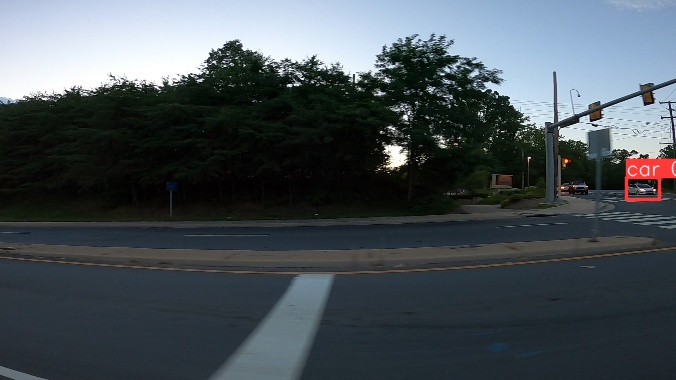

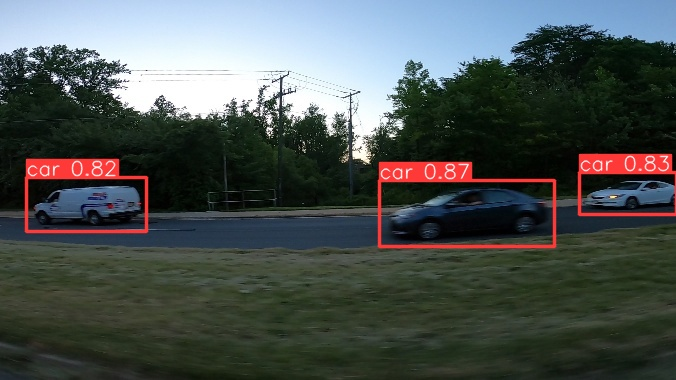

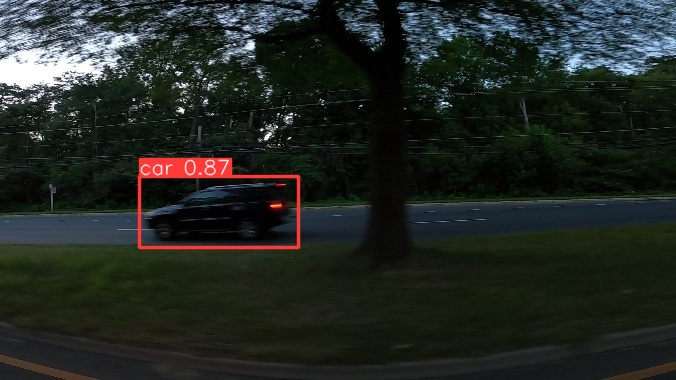

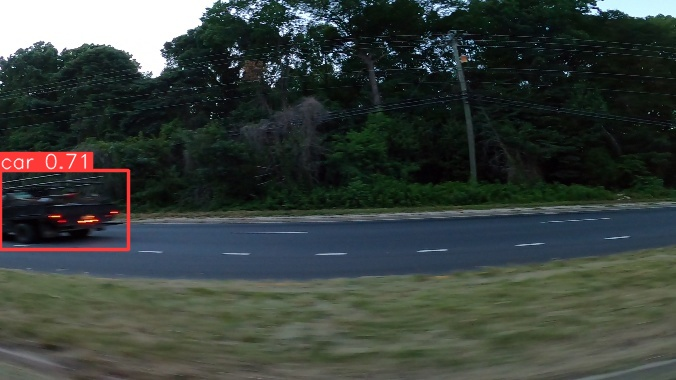

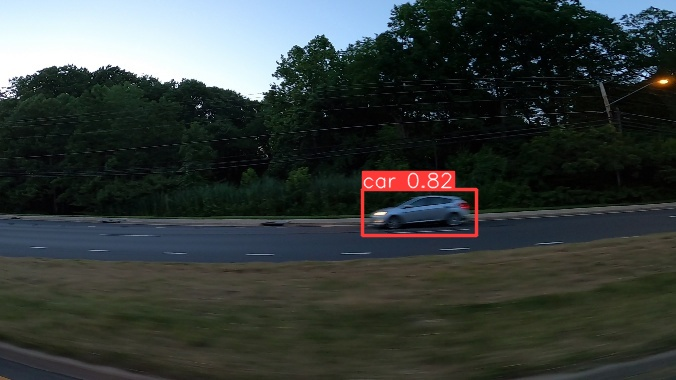

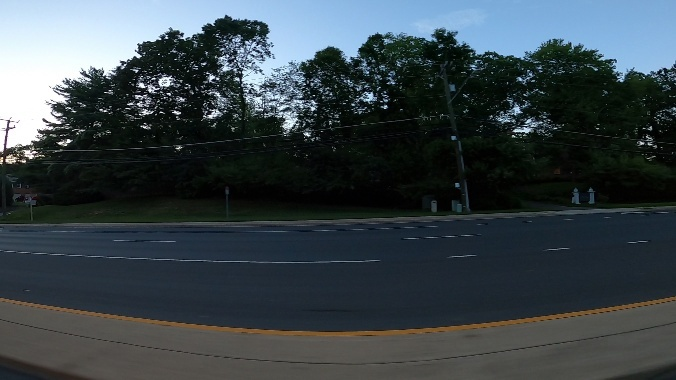

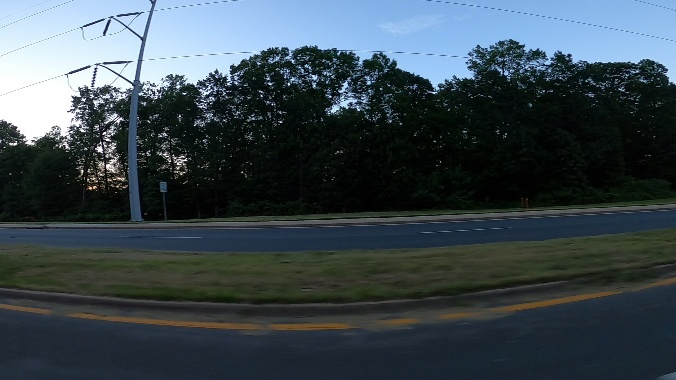

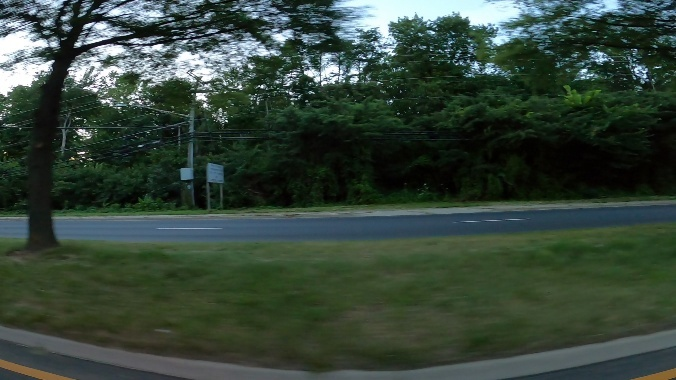

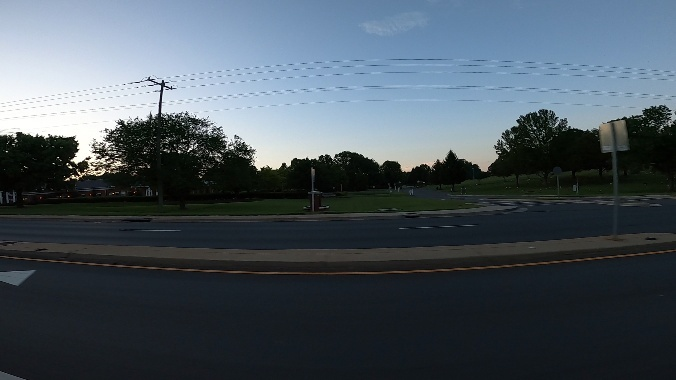

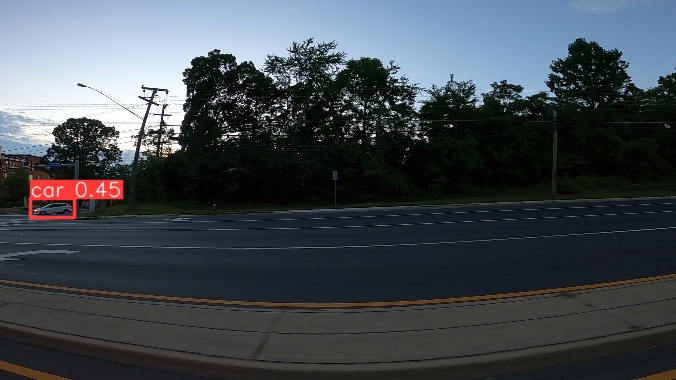

In [22]:
# display result
files = glob.glob("runs/detect/predict/*")
for i in range(0, 60, 3):
    img = Image(files[i])
    display(img)

## Next Steps